In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=6, linewidth=110)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import uncertaintysampling as us

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(us)

import constants
imp.reload(constants)
from constants import *

In [3]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

# Load surrogate model

In [4]:
nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=2, npoints=10000)

(<matplotlib.figure.Figure at 0x10e6c8c50>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x10e6d15d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x10e956210>))

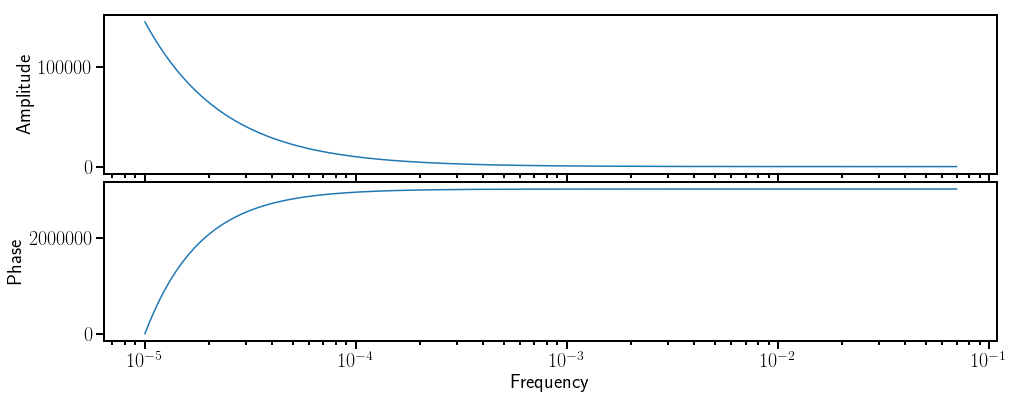

In [5]:
params = np.array([1., 0., 0., 1000., 1000.])
h = sur.geometric_waveform(params)
wave.plot_waveforms_fd([h])

In [11]:
print sur.mf_phase
print sur.mf_phase[:33]

[ 0.000244  0.000283  0.000328  0.000381  0.000442  0.000513  0.000596  0.000691  0.000802  0.000931  0.001081
  0.001255  0.001456  0.00169   0.001961  0.002276  0.002642  0.003066  0.003559  0.004131  0.004794  0.005564
  0.006458  0.007495  0.008699  0.010096  0.011717  0.013599  0.015784  0.018319  0.021261  0.024676  0.028639
  0.033239  0.038578  0.044774  0.051966  0.060313  0.07    ]
[ 0.000244  0.000283  0.000328  0.000381  0.000442  0.000513  0.000596  0.000691  0.000802  0.000931  0.001081
  0.001255  0.001456  0.00169   0.001961  0.002276  0.002642  0.003066  0.003559  0.004131  0.004794  0.005564
  0.006458  0.007495  0.008699  0.010096  0.011717  0.013599  0.015784  0.018319  0.021261  0.024676  0.028639]


# Add new points with uncertainty sampling

In [12]:
original_points = sur.dphase_gp_list[0].X_train_
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'
dphase_gp_list = sur.dphase_gp_list
# Use the first nmax nodes in calculating the RMS phase error
nmax = 33

sampler = us.UncertaintySampling(original_points, limits, kernel_type, dphase_gp_list, nmax=nmax)

In [24]:
sampler.add_new_points(100, nbasinjumps=50, nfun_eval_per_basin=15, verbose=True)

0 err_new=0.136492367018, neval=4878, evaluation time=1148.09342599
point_new=[  6.136154e-01  -5.000000e-01   2.901847e-02   3.001320e+03   2.542108e+03]
1 err_new=0.164395916899, neval=4908, evaluation time=1136.8265121
point_new=[  6.929336e-01   5.000000e-01   5.000000e-01   5.000000e+03   5.000000e+03]
2 err_new=0.165894573372, neval=4944, evaluation time=1159.50436616
point_new=[  9.248820e-01  -5.000000e-01   5.000000e-01   1.800442e+03   2.405827e-05]
3 err_new=0.172896870033, neval=4686, evaluation time=1103.91931796
point_new=[ 0.580722  0.5       0.029713  0.050671  0.      ]
4 err_new=0.148275587748, neval=4734, evaluation time=1104.15920401
point_new=[  7.729198e-01  -1.806036e-01  -4.999997e-01   5.000000e+03   1.331997e-03]
5 err_new=0.150298236671, neval=4890, evaluation time=1159.45932102
point_new=[  3.962524e-01  -1.632868e-02  -5.000000e-01   1.995607e+03   3.820123e+03]
6 err_new=0.162964653972, neval=4920, evaluation time=1182.18043995
point_new=[  5.917812e-01   

In [26]:
points_errors = np.concatenate((sampler.new_points.T, np.array([sampler.new_errors]))).T
print len(points_errors)

#np.savetxt('../../data/TEOBv4_20hz/uncsamp_from_lhd_trainset.txt', points_errors)

500


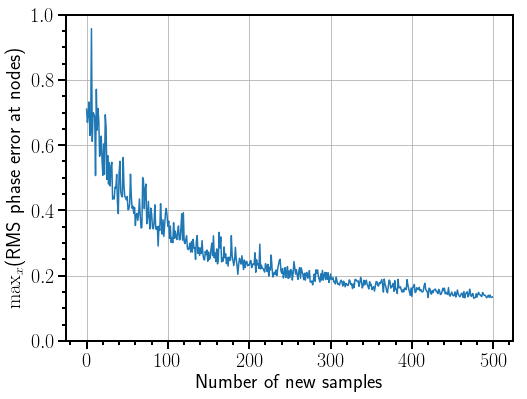

In [27]:
fig, axes = plt.subplots(1, figsize=(8, 6))
axes.plot(sampler.new_errors)
#axes.scatter(360, 0.343, label='')
axes.set_xlabel('Number of new samples')
axes.set_ylabel(r'$\max_x$(RMS phase error at nodes)')
axes.minorticks_on()
axes.set_ylim(0, 1)
axes.grid()

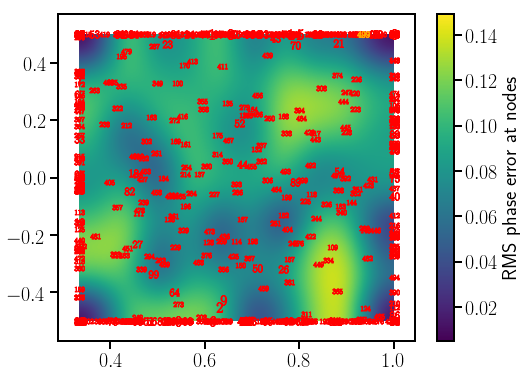

In [28]:
x0, x1, x2, x3, x4 = 1.0, 0.5, -0.5, 5000., 0.
def mismatch_error(x0, x1):
    point = np.array([x0, x1, x2, x3, x4])
    return -sampler.negative_error(point)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 10
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 10
plot_2d_func(ax1, mismatch_error, xlow, xhigh, nx, ylow, yhigh, ny, 
             colorbar_label=r'RMS phase error at nodes')
plot_numbered_points(ax1, sampler.new_points)

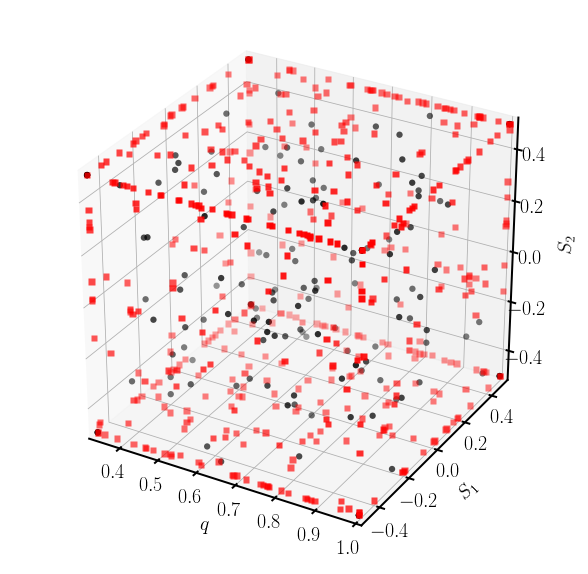

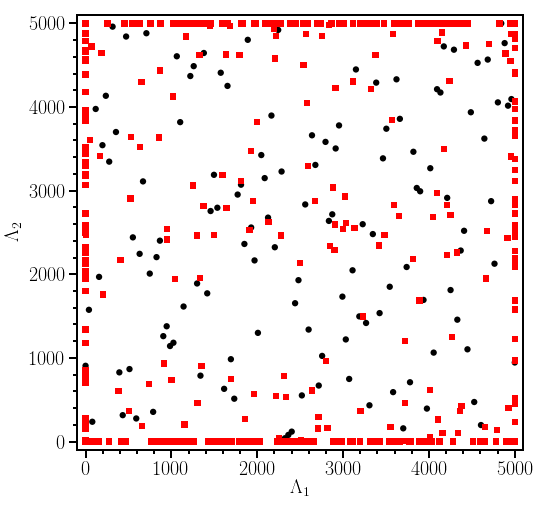

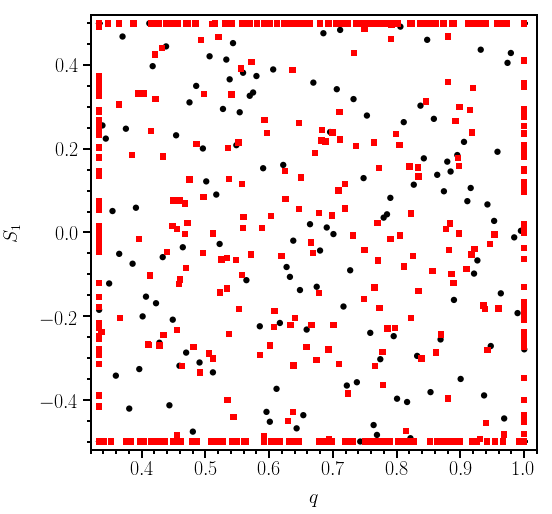

In [29]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111, projection='3d')

x, y, z = original_points[:, 0], original_points[:, 1], original_points[:, 2]
axes.scatter(x, y, z, c='k', edgecolor='none', marker='o', s=40)

x, y, z = sampler.new_points[:, 0], sampler.new_points[:, 1], sampler.new_points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.333, 1.0)
axes.set_ylim(-0.5, 0.5)
axes.set_zlim(-0.5, 0.5)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.set_zlabel('$S_2$', labelpad=18)
#axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 3], original_points[:, 4]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 3], sampler.new_points[:, 4]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(-100, 5100)
axes.set_ylim(-100, 5100)
axes.set_xlabel('$\Lambda_1$')
axes.set_ylabel('$\Lambda_2$')
axes.minorticks_on()


fig, axes = plt.subplots(1, figsize=(8, 8))

x, y = original_points[:, 0], original_points[:, 1]
axes.scatter(x, y, c='k', edgecolor='none', marker='o', s=40)

x, y = sampler.new_points[:, 0], sampler.new_points[:, 1]
axes.scatter(x, y, c='r', edgecolor='none', marker='s', s=40)

axes.set_xlim(0.32, 1.02)
axes.set_ylim(-0.52, 0.52)
axes.set_xlabel('$q$', labelpad=10)
axes.set_ylabel('$S_1$', labelpad=15)
axes.minorticks_on()

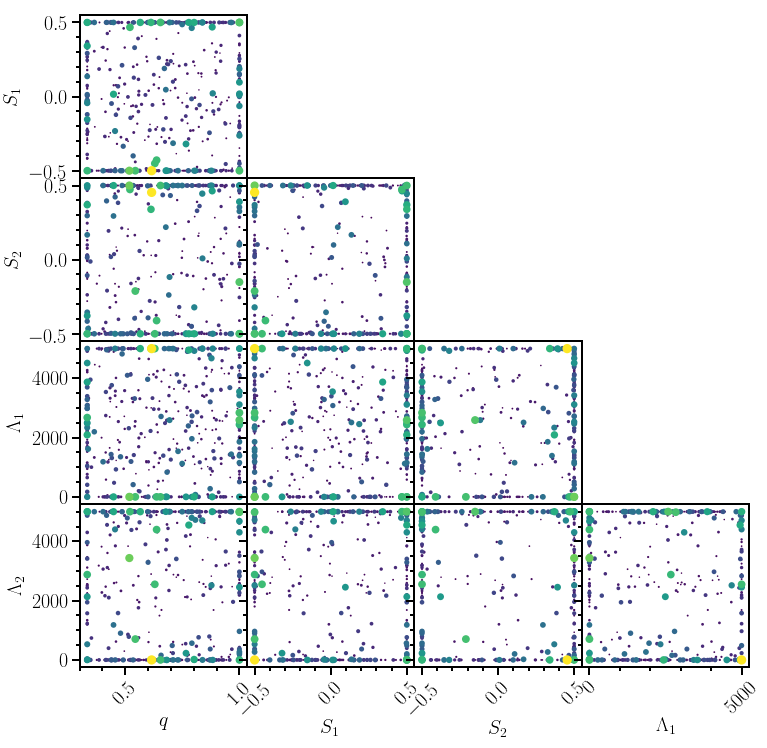

In [30]:
labels = [r'$q$', r'$S_1$', r'$S_2$', r'$\Lambda_1$', r'$\Lambda_2$']
params = sampler.new_points
error = sampler.new_errors
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, figsize=(10, 10))

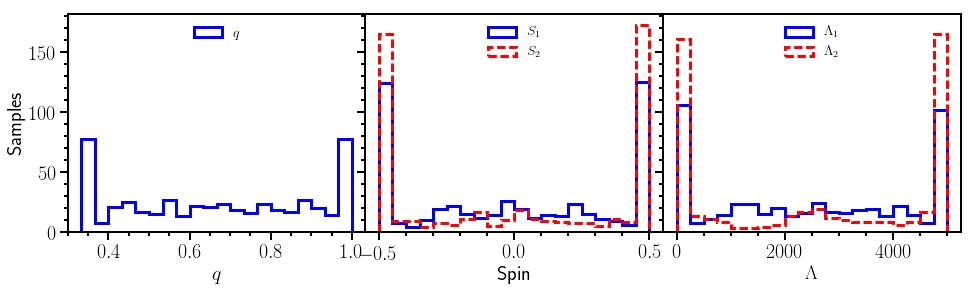

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 4))
fig.subplots_adjust(wspace=0.0)


# Mass ratio
ax1.hist(sampler.new_points[:, 0], bins=20, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$q$')
ax1.set_xlabel(labels[0])
ax1.set_ylabel('Samples')
ax1.legend(loc='upper center', frameon=False)
ax1.minorticks_on()


# Spins
ax2.hist(sampler.new_points[:, 1], bins=20, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$S_1$')

ax2.hist(sampler.new_points[:, 2], bins=20, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$S_2$')

ax2.set_xlabel('Spin')
ax2.legend(loc='upper center', frameon=False)
ax2.minorticks_on()


# Tidal parameters
ax3.hist(sampler.new_points[:, 3], bins=20, histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\Lambda_1$')

ax3.hist(sampler.new_points[:, 4], bins=20, histtype='step', 
          ls='--', lw=3, color='red', alpha=1.0, label=r'$\Lambda_2$')

ax3.set_xlabel(r'$\Lambda$')
ax3.legend(loc='upper center', frameon=False)
ax3.minorticks_on()